Loading data from wells_with_bht.xlsx...
Data loaded successfully. Rows before cleaning: 11201
Found columns: ['Name', 'Api', 'Country', 'Status', 'Well Type', 'Latitude', 'Longitude', 'True Vertical Depth (ft)', 'True Vertical Depth (km)', 'Interpolated gradient', 'BHT', 'Suitable for ']
Checking and cleaning coordinate data...
Number of wells for map after cleaning: 11201
Creating GeoDataFrame...
GeoDataFrame created. Initial CRS: EPSG:4326
Reprojecting to EPSG:3857 for basemap and density calculation...
Reprojection successful.
Calculating well density (KDE)...
Density calculation complete.
Creating static map...
Plotting wells colored by density...
Density points plotted.
Adding density legend (colorbar)...
Density legend added.
Adding basemap (may take a moment)...
Basemap added.
Density map successfully saved to: map_wells_density_green_red.png

Script finished.


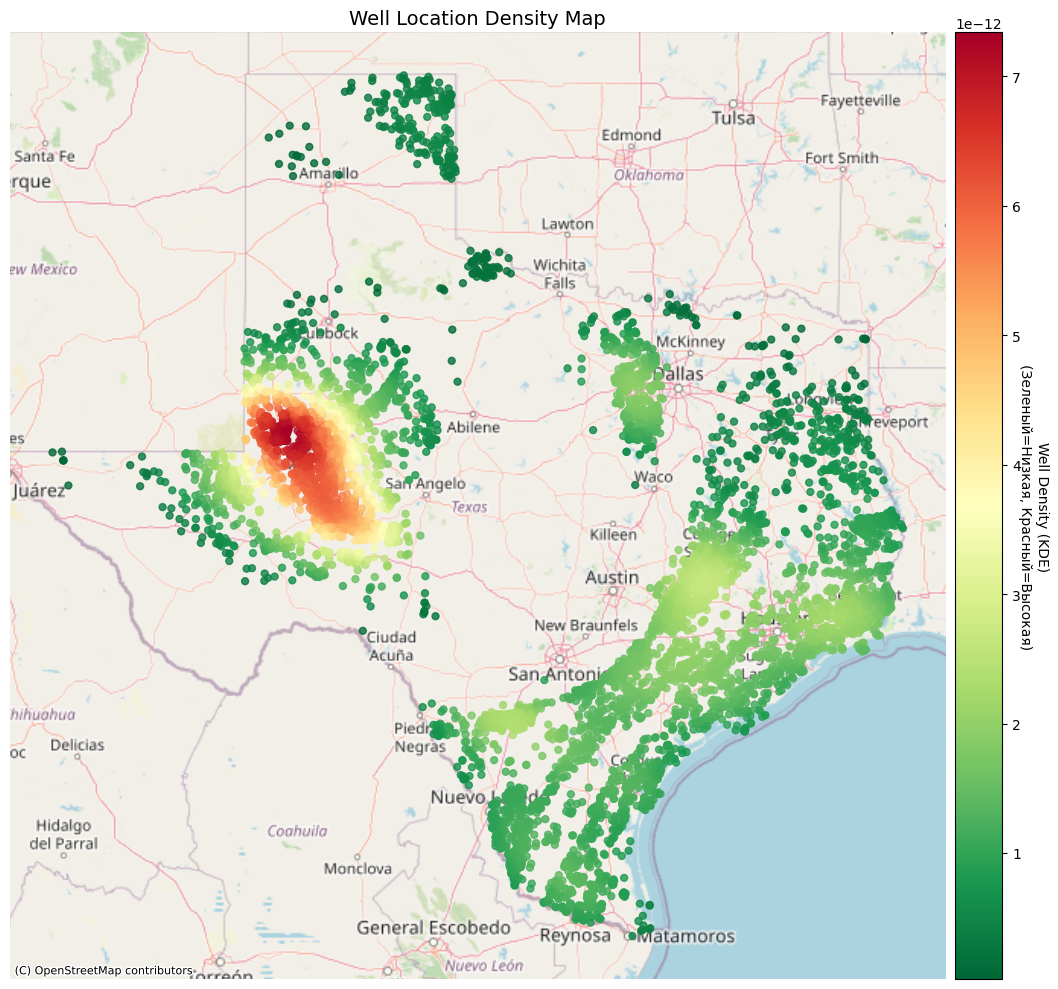

In [6]:
# Imports
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # For better legend placement
import contextily as ctx # For basemap
from scipy.stats import gaussian_kde # For density calculation

# --- Constants ---
# Path to the Excel file (ensure this is correct)
EXCEL_FILE_PATH = 'wells_with_bht.xlsx'
# Name of the output image file
OUTPUT_IMAGE_FILE = 'map_wells_density_green_red.png' # Changed output name slightly
# Expected column names for coordinates (check your Excel file!)
LAT_COL = 'Latitude'
LON_COL = 'Longitude'
# Name for the calculated density column
DENSITY_COL = 'Well Density (KDE)'
# Coordinate Reference Systems
CRS_LATLON = 'EPSG:4326' # Input CRS (WGS84)
CRS_MERCATOR = 'EPSG:3857' # CRS for contextily basemap and KDE calculation

# --- 1. Load Data from Excel ---
print(f"Loading data from {EXCEL_FILE_PATH}...")
try:
    # Use read_excel for .xlsx files
    # Ensure openpyxl is installed: pip install openpyxl
    df = pd.read_excel(EXCEL_FILE_PATH)
    print(f"Data loaded successfully. Rows before cleaning: {len(df)}")
    print(f"Found columns: {list(df.columns)}")
except FileNotFoundError:
    print(f"Error: File '{EXCEL_FILE_PATH}' not found.")
    print("Please ensure the file is in the same directory or provide the full path.")
    exit()
except ImportError:
    print("Error: The 'openpyxl' library is required to read Excel .xlsx files.")
    print("Please install it: pip install openpyxl")
    exit()
except Exception as e:
    print(f"An error occurred while reading the Excel file: {e}")
    exit()

# --- 2. Prepare and Clean Data ---
# Check for required coordinate columns
required_cols = [LAT_COL, LON_COL]
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"\n!!! Error: Missing required columns in '{EXCEL_FILE_PATH}': {missing_cols}")
    print(f"    Expected columns: {required_cols}")
    print(f"    Found columns: {list(df.columns)}")
    print("    Please rename columns in the file or update LAT_COL/LON_COL constants.")
    exit()

# Select necessary columns
try:
    df_map = df[required_cols].copy()
except KeyError:
    print(f"Critical error selecting columns {required_cols}.")
    exit()

# Enhanced cleaning (NaN, inf, non-numeric)
print("Checking and cleaning coordinate data...")
for col in required_cols:
    # Convert to numeric, making errors NaN
    df_map[col] = pd.to_numeric(df_map[col], errors='coerce')
    # Replace infinite values with NaN
    df_map.replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove rows with any NaN in coordinate columns
initial_rows = len(df_map)
df_map.dropna(subset=required_cols, inplace=True)
removed_rows = initial_rows - len(df_map)
if removed_rows > 0:
    print(f"Removed {removed_rows} rows with missing, infinite, or non-numeric coordinates.")

# Check if data remains after cleaning
if df_map.empty:
    print("Error: No valid coordinate data remaining after cleaning.")
    exit()

# Final type conversion for safety
try:
    df_map[LAT_COL] = df_map[LAT_COL].astype(float)
    df_map[LON_COL] = df_map[LON_COL].astype(float)
except ValueError as e:
    print(f"Critical error during final coordinate type conversion: {e}")
    exit()

print(f"Number of wells for map after cleaning: {len(df_map)}")

# --- 3. Create GeoDataFrame ---
print("Creating GeoDataFrame...")
try:
    # Create geometry from longitude and latitude columns
    gdf = gpd.GeoDataFrame(
        df_map,
        geometry=gpd.points_from_xy(df_map[LON_COL], df_map[LAT_COL]),
        crs=CRS_LATLON # Set the initial coordinate system (WGS84)
    )
    print(f"GeoDataFrame created. Initial CRS: {gdf.crs}")
except Exception as e:
    print(f"Error creating GeoDataFrame: {e}")
    exit()

# --- 4. Reproject and Calculate Density ---
print(f"Reprojecting to {CRS_MERCATOR} for basemap and density calculation...")
try:
    gdf_mercator = gdf.to_crs(CRS_MERCATOR)
    print("Reprojection successful.")
except Exception as e:
    print(f"Error during CRS reprojection: {e}")
    print("Attempting to proceed without basemap, density calculation might be less accurate.")
    # Use original gdf if reprojection fails, but KDE might not work well
    gdf_mercator = gdf # Fallback

# Calculate Kernel Density Estimation (KDE) only if reprojection was successful
if gdf_mercator.crs == CRS_MERCATOR:
    print("Calculating well density (KDE)...")
    try:
        # Extract X and Y coordinates in the projected system
        x = gdf_mercator.geometry.x.values
        y = gdf_mercator.geometry.y.values
        xy = np.vstack([x, y])

        # Perform KDE
        # Bandwidth 'bw_method' can be adjusted ('scott', 'silverman', or a scalar value)
        # A smaller bandwidth results in more localized density peaks.
        kde = gaussian_kde(xy, bw_method='scott')

        # Evaluate the KDE on each point to get its density value
        density_values = kde(xy)

        # Add density values as a new column
        gdf_mercator[DENSITY_COL] = density_values
        print("Density calculation complete.")
        density_calculated = True
    except Exception as e:
        print(f"Error during KDE calculation: {e}. Cannot color points by density.")
        density_calculated = False
else:
    print("Skipping density calculation due to CRS issues.")
    density_calculated = False

# --- 5. Create Static Map ---
print("Creating static map...")
fig, ax = plt.subplots(1, 1, figsize=(12, 10)) # Adjust figure size if needed

# Plotting parameters
# !!! ИЗМЕНЕНО: Установлена цветовая карта Green -> Yellow -> Red !!!
cmap = 'RdYlGn_r'
marker_size = 25
alpha = 0.8 # Slightly transparent markers

# Plot points, colored by density if calculated
if density_calculated:
    print("Plotting wells colored by density...")
    vmin = gdf_mercator[DENSITY_COL].min() # Min density for color scale
    vmax = gdf_mercator[DENSITY_COL].max() # Max density for color scale
    plot = gdf_mercator.plot(
        column=DENSITY_COL, # Column to determine color
        cmap=cmap,          # Use the updated colormap
        markersize=marker_size,
        alpha=alpha,
        ax=ax,
        legend=False, # Disable default legend, add manually later
        vmin=vmin,
        vmax=vmax
    )
    print("Density points plotted.")
    # Add colorbar legend manually
    print("Adding density legend (colorbar)...")
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = [] # Dummy data for ScalarMappable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(sm, cax=cax)
    # !!! ИЗМЕНЕНО: Обновлена метка легенды !!!
    cbar.set_label(f'{DENSITY_COL}\n(Зеленый=Низкая, Красный=Высокая)', rotation=270, labelpad=20)
    print("Density legend added.")

else:
    # Fallback: Plot all points with a single color if density failed
    print("Plotting wells with a single color (density calculation failed)...")
    gdf_mercator.plot(
        color='blue', # Default color
        markersize=marker_size,
        alpha=alpha,
        ax=ax
    )
    print("Wells plotted (uniform color).")

# Add basemap if reprojection was successful
if gdf_mercator.crs == CRS_MERCATOR:
    print("Adding basemap (may take a moment)...")
    try:
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
        # Other options: ctx.providers.Stamen.Terrain, ctx.providers.CartoDB.Positron
        print("Basemap added.")
    except Exception as e:
        print(f"Warning: Failed to add basemap: {e}. Map will be without background.")
else:
     print("Skipping basemap addition due to CRS issues.")

# Set title and turn off axes
ax.set_title('Well Location Density Map', fontsize=14)
ax.set_axis_off() # Hide X and Y axis labels/ticks

# --- 6. Save and Display ---
plt.tight_layout() # Adjust layout to prevent labels overlapping
try:
    # !!! ИЗМЕНЕНО: Имя выходного файла !!!
    plt.savefig(OUTPUT_IMAGE_FILE, dpi=300, bbox_inches='tight')
    print(f"Density map successfully saved to: {OUTPUT_IMAGE_FILE}")
except Exception as e:
    print(f"Error saving the map image: {e}")

# plt.show() # Uncomment this line if you want the map to display in a Python window

print("\nScript finished.")
